In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyearth import Earth

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.neighbors import LocalOutlierFactor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import StackingRegressor, AdaBoostRegressor

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, OneHotEncoder
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error

In [2]:
cowpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Cowpea')    ; cowpea['crop']   = 'cowpea'
maize = pd.read_excel('../data/prepared.xlsx', sheet_name='Maize')      ; maize['crop']    = 'maize'
rice = pd.read_excel('../data/prepared.xlsx', sheet_name='Rice')        ; rice['crop']     = 'rice'
chickpea = pd.read_excel('../data/prepared.xlsx', sheet_name='Chickpea'); chickpea['crop'] = 'chickpea'
mustard = pd.read_excel('../data/prepared.xlsx', sheet_name='Mustard')  ; mustard['crop']  = 'mustard'

In [3]:
data = pd.concat([cowpea, rice, maize, chickpea, mustard], axis=0).reset_index(drop=True)

In [4]:
clf = LocalOutlierFactor(n_neighbors=20)

new_data = []
org_cols = data.columns
for i, outlier_label in enumerate(clf.fit_predict(data[['GSR', 'CT']])):
    if outlier_label==1:
        new_data.append(data.iloc[i,:])
data = pd.DataFrame(new_data, columns=org_cols)

In [5]:
data = data[(data['GSR']<300) | (data['Rn']>150)]
data = data[(data['Rn']<500) | (data['crop']!='cowpea')]
data = data[(data['Rn']<400) | (data['GSR']>500) | (data['crop']!='rice')]
data = data[(data['Rn']<300) | (data['GSR']>375)]

In [6]:
data.loc[:, 'Time'] = data.loc[:, 'Time'].apply(lambda x: x.hour)
data.loc[:, 'timesin'] = np.sin(data.loc[:, 'Time'] * (2 * np.pi) / 12)
data.loc[:, 'timecos'] = np.cos(data.loc[:, 'Time'] * (2 * np.pi) / 12)

In [7]:
df = pd.get_dummies(data[['crop']])
data = pd.concat([df, data], axis=1)

In [8]:
feature_cols = [c for c in data.columns if c not in ['ST_5cm','ST_10cm','ST_15cm','Date','Time','crop','Rn']]
X = data[feature_cols]
y = data['Rn']

In [9]:
estimators = [
    ('GBR', GradientBoostingRegressor(random_state=42)),
    ('RF', RandomForestRegressor(random_state=42)),
    ('Ridge', Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('poly2', PolynomialFeatures(degree=2, interaction_only=True)),
        ('ridgef', Ridge(alpha=40, random_state=42))
    ])),
#     ('SVR', Pipeline(steps=[
#         ('scaler', StandardScaler()),
#         ('svrf', SVR(kernel='rbf', gamma='auto', C=1))
#     ])),
    ('Spline', Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('splinef', Earth(max_degree=5, minspan_alpha=0.01, smooth=True, thresh=0., feature_importance_type='gcv'))
    ])),
    ('Adaboost', AdaBoostRegressor())
]

In [10]:
# Use KFold croos validation
NUM_FOLDS = 10
kfold = KFold(n_splits=NUM_FOLDS)

In [11]:
# Train all models
def train(estimators, X, y, cv, scoring, verbose):
    if verbose:
        print("Scoring criteria:", str(scoring))
        print("CV:", cv)
        print("y std:", np.std(y))
        print('\n')
    for model in estimators if isinstance(estimators, list) else [estimators]:
        model[1].fit(X, y)
        if verbose:
            cross_scores = cross_val_score(model[1], X, y, scoring=scoring, cv=cv)
            print(model[0], "mean cv score:", np.mean(cross_scores))
            print(model[0], "all cv scores:", cross_scores)
            print('\n')

In [12]:
# Inititalize variables
gsr_idx = X.columns.tolist().index('GSR')
all_xidxs = []
all_train_mse  = {model[0]:[] for model in estimators}
all_train_rmse = {model[0]:[] for model in estimators}
all_valid_mse  = {model[0]:[] for model in estimators}
all_valid_rmse = {model[0]:[] for model in estimators}
all_preds      = {model[0]:[] for model in estimators}
all_trues      = {model[0]:[] for model in estimators}

for (t_, v_) in kfold.split(X, y):
    # Train all the models
    train(estimators=estimators, X=X.iloc[t_], y=y.iloc[t_], cv=NUM_FOLDS, scoring='neg_root_mean_squared_error', verbose=0)
    # Append valid idxs
    all_xidxs.extend(v_)
    # Find loss
    for model in estimators:
        y_train_pred = model[1].predict(X.iloc[t_][feature_cols]).reshape(-1,1)
        y_train_true = y.iloc[t_].values.reshape(-1,1)
        y_valid_pred = model[1].predict(X.iloc[v_][feature_cols]).reshape(-1,1)
        y_valid_true = y.iloc[v_].values.reshape(-1,1)
        
        train_mse = mean_squared_error(y_train_true, y_train_pred)
        train_rmse = np.sqrt(train_mse)
        valid_mse = mean_squared_error(y_valid_true, y_valid_pred)
        valid_rmse = np.sqrt(valid_mse)
        
        all_train_mse[model[0]].extend([train_mse])
        all_train_rmse[model[0]].extend([train_rmse])
        all_valid_mse[model[0]].extend([valid_mse])
        all_valid_rmse[model[0]].extend([valid_rmse])
        
        all_preds[model[0]].extend(y_valid_pred)
        all_trues[model[0]].extend(y_valid_true)

In [13]:
# Create multi-index dataframe
num_estimators = len(estimators)
listA = ['Train', 'Valid']
listB = list(range(1,NUM_FOLDS+1)) + ['Mean']

idx = pd.MultiIndex.from_product([listA, listB], names=['Dataset type', 'Fold'])

rmse_errors = [[np.nan for _ in range(num_estimators)] for _ in range(len(listA)*len(listB))]
model_names = None

for li, errors in enumerate([all_train_rmse, all_valid_rmse]):
    if model_names is None:
        model_names = errors.keys()
    for j, error_list in enumerate(errors.values()):
        for i in range(NUM_FOLDS):
            rmse_errors[i+li*len(listB)][j] = error_list[i]
        rmse_errors[(li+1)*len(listB)-1][j] = np.mean(error_list)

In [14]:
def highlight_mean_row(x):
    df = x.copy()
    df.loc[:,:] = 'background-color: dark'
    df.loc['Train','Mean'] = 'background-color: blue'
    df.loc['Valid','Mean'] = 'background-color: blue'
    return df

print("RMSE Table:")
pd.DataFrame(rmse_errors, index=idx, columns=model_names).style.apply(highlight_mean_row, axis=None)

RMSE Table:


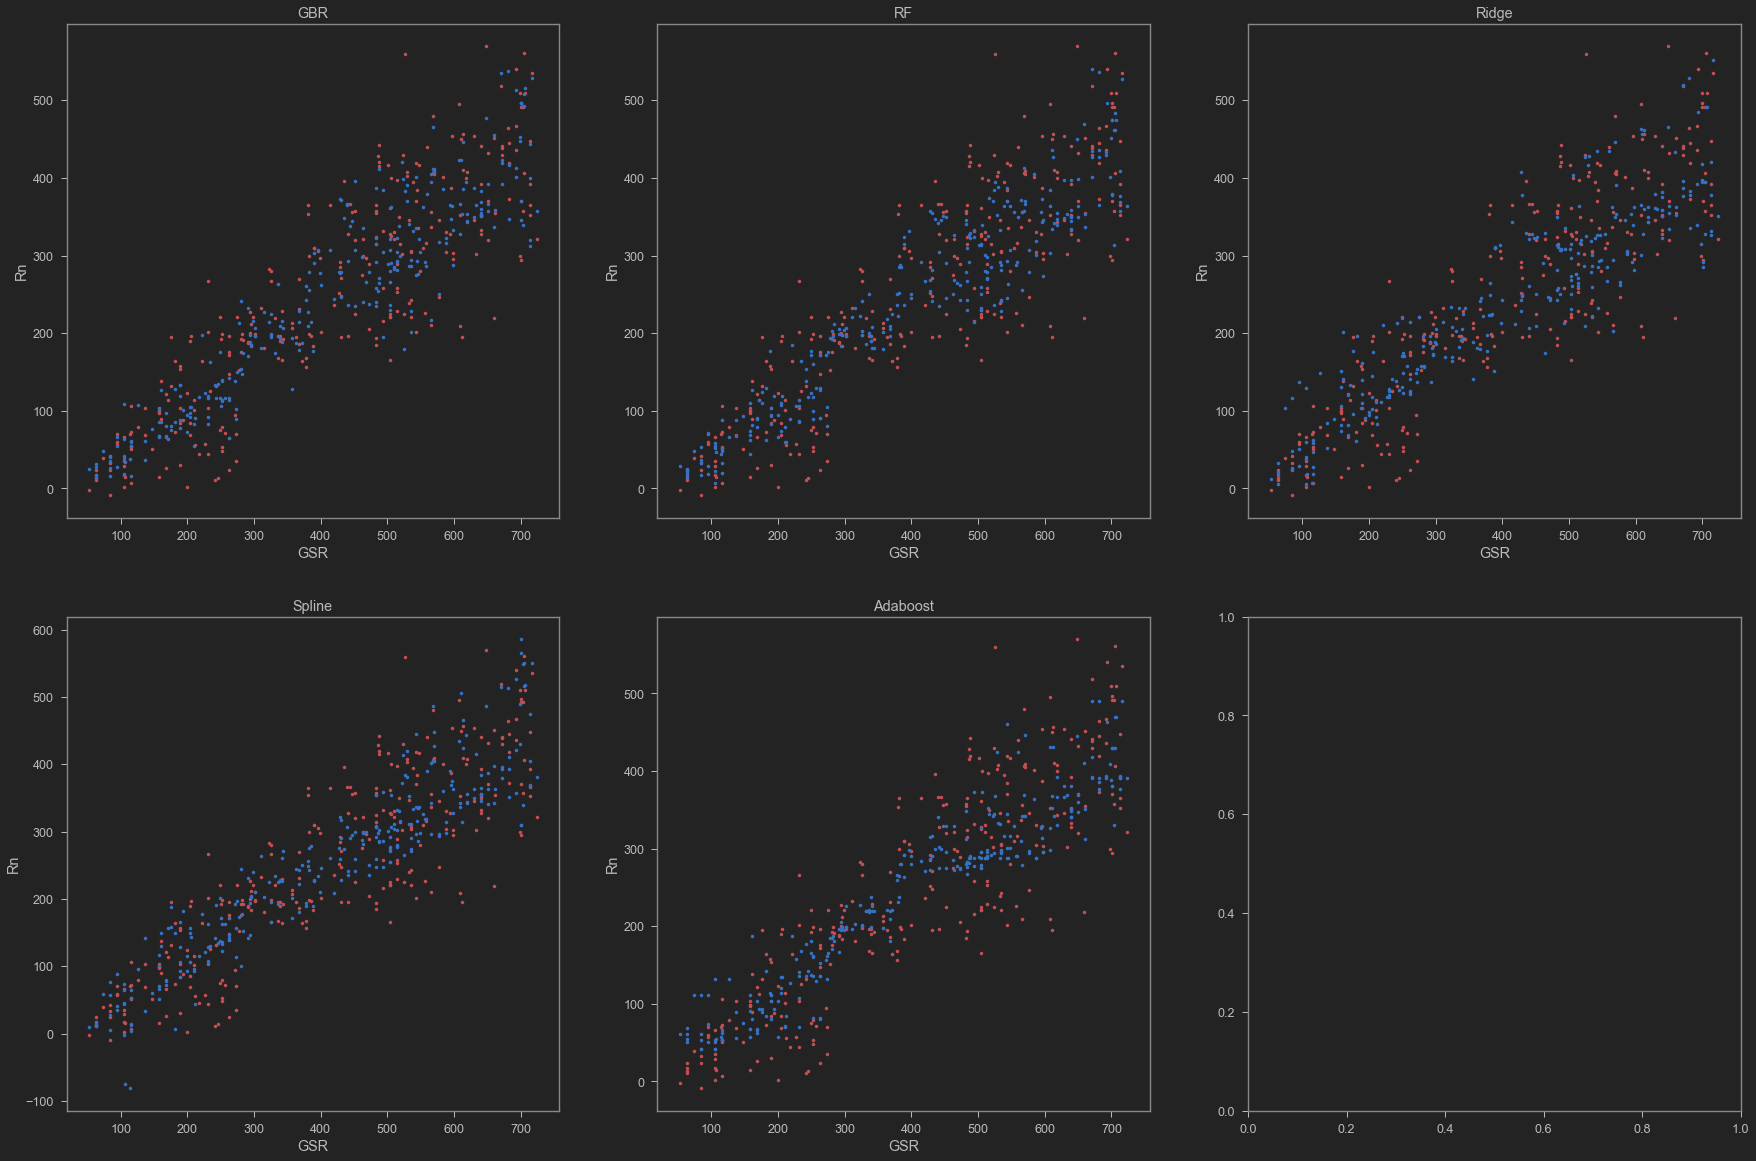

In [15]:
#Plot the model
fig, axes = plt.subplots(nrows=int(np.ceil(num_estimators/3)), ncols=3, figsize=(30,20))

# Initialize axes
if axes.ndim<2:
    axes = np.expand_dims(axes, axis=0)
R = len(axes); C = len(axes[0]); r = 0; c = 0

for model in estimators:
    axes[r, c].plot(X.iloc[all_xidxs,gsr_idx],all_trues[model[0]],'r.')
    axes[r, c].plot(X.iloc[all_xidxs,gsr_idx],all_preds[model[0]],'b.')
    axes[r, c].set_xlabel('GSR')
    axes[r, c].set_ylabel('Rn')
    axes[r, c].set_title(model[0])
    
    c+=1
    if c==C:
        r+=1; c=0

plt.show()

In [16]:
stacked_estimator = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(random_state=42)
)

In [20]:
all_stacked_mses = []
all_stacked_rmses = []
for f_, (t_, v_) in enumerate(kfold.split(X, y)):
    stacked_estimator.fit(X.iloc[t_], y.iloc[t_])
    y_pred = stacked_estimator.predict(X.iloc[v_][feature_cols]).reshape(-1,1)
    y_true = y.iloc[v_].values.reshape(-1,1)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    
    all_stacked_mses.append(mse)
    all_stacked_rmses.append(rmse)
    print(f"Fold:{f_}, Stacked estimator MSE: {mse:.2f}, Stacked estimator RMSE: {rmse:.2f}")

print("\nStacked estimator mean MSE:", np.mean(all_stacked_mses))
print("Stacked estimator mean RMSE:", np.mean(all_stacked_rmses))

Fold:0, Stacked estimator MSE: 5370.48, Stacked estimator RMSE: 73.28
Fold:1, Stacked estimator MSE: 2885.87, Stacked estimator RMSE: 53.72
Fold:2, Stacked estimator MSE: 5926.85, Stacked estimator RMSE: 76.99
Fold:3, Stacked estimator MSE: 6687.93, Stacked estimator RMSE: 81.78
Fold:4, Stacked estimator MSE: 4129.60, Stacked estimator RMSE: 64.26
Fold:5, Stacked estimator MSE: 5428.61, Stacked estimator RMSE: 73.68
Fold:6, Stacked estimator MSE: 2051.28, Stacked estimator RMSE: 45.29
Fold:7, Stacked estimator MSE: 3655.18, Stacked estimator RMSE: 60.46
Fold:8, Stacked estimator MSE: 2516.46, Stacked estimator RMSE: 50.16
Fold:9, Stacked estimator MSE: 3233.05, Stacked estimator RMSE: 56.86
Stacked estimator mean MSE: 4188.531804132164
Stacked estimator mean RMSE: 63.64841738264808
